In [85]:
#!pip uninstall numpy
# !pip install scikit-learn
#!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt

In [86]:
data = pd.read_csv("/kaggle/input/psrana-test/Fuel_cell_performance_data-Full.csv")
df = data.drop([f'Target{i}' for i in range(1,4)], axis=1)
df = df.drop(['Target5'], axis=1)
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Target4
0,52.9,1.33,49.1,37.13,129.43,35.0,0.281,112.7,207,0.55,98.971,2.87,1362,15.9,429,4.19
1,87.6,2.12,48.8,42.10,171.07,37.6,0.153,157.4,188,0.86,101.179,2.34,5130,26.1,1819,5.19
2,73.3,2.72,93.8,20.11,163.69,44.3,0.367,348.7,270,1.87,98.919,2.13,7811,16.7,1763,7.77
3,65.6,2.58,48.1,35.11,63.37,32.5,0.279,321.2,322,1.75,101.560,2.91,1641,32.1,203,8.40
4,39.6,2.58,49.3,32.93,63.40,47.0,0.149,205.6,203,1.55,98.148,1.93,7648,27.5,276,4.75


In [87]:
r,c = df.shape

In [88]:
for i in range(c):
    s = 0
    for j in range(r):
        s += df.iloc[j,i]**2
    s = s**0.5
    if i< c-1:
        df.iloc[:,i] = df.iloc[:,i]*10/s
    else:
        df.iloc[:,i] = df.iloc[:,i]/s
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Target4
0,0.269758,0.200602,0.227542,0.369729,0.320520,0.289986,0.338158,0.137274,0.265163,0.133123,0.312946,0.397840,0.073600,0.194963,0.118641,0.021060
1,0.446708,0.319756,0.226152,0.419219,0.423637,0.311527,0.184122,0.191721,0.240825,0.208156,0.319928,0.324372,0.277217,0.320033,0.503049,0.026086
2,0.373786,0.410253,0.434694,0.200249,0.405361,0.367039,0.441652,0.424733,0.345865,0.452617,0.312782,0.295261,0.422094,0.204772,0.487562,0.039054
3,0.334521,0.389137,0.222908,0.349615,0.156929,0.269272,0.335752,0.391237,0.412476,0.423572,0.321133,0.403385,0.088677,0.393604,0.056140,0.042221
4,0.201936,0.389137,0.228469,0.327907,0.157004,0.389409,0.179308,0.250430,0.260039,0.375164,0.310344,0.267537,0.413286,0.337200,0.076328,0.023875


In [89]:
drop = []
for i in range(15):
    corr = df.iloc[:,i].corr(df.iloc[:,-1])
    print(f"The correlation score of F{i} with Target is: {corr}")
    if corr**2 < 0.001**2:
        drop.append(f'F{i+1}')
        print(f"Drop Col {i+1}")
df = df.drop(drop, axis=1)

The correlation score of F0 with Target is: -0.050695505296193225
The correlation score of F1 with Target is: 0.004134735605715825
The correlation score of F2 with Target is: 0.01369835332918546
The correlation score of F3 with Target is: -0.043393139384464374
The correlation score of F4 with Target is: -0.04140873629750461
The correlation score of F5 with Target is: 0.02994861095452157
The correlation score of F6 with Target is: -0.021208267537185074
The correlation score of F7 with Target is: 0.02396602983457102
The correlation score of F8 with Target is: -0.09155621835659718
The correlation score of F9 with Target is: 0.008111413165597409
The correlation score of F10 with Target is: -0.10340123822846961
The correlation score of F11 with Target is: 0.005355915839672036
The correlation score of F12 with Target is: 0.0010432739735408787
The correlation score of F13 with Target is: -0.005606167859236927
The correlation score of F14 with Target is: -0.002231487767003861


In [90]:
targ = df.iloc[:,-1]
#print(targ.max(), targ.min())
avg = sum(targ)/len(targ)
print(avg)

0.029452148998898454


In [91]:
rows, col = df.shape
#print(df.shape)
print(df.shape)

(1000, 16)


## Making DL Models

In [92]:
class ArpitSModel(nn.Module):
    def __init__(self):
        super(ArpitSModel, self).__init__()
        
        self.Relu3Layer = nn.Sequential(
        nn.Linear(15,10),
        nn.LeakyReLU(inplace=True),
        nn.Linear(10,8),
        nn.LeakyReLU(inplace=True),
        nn.Linear(8, 3),
        nn.LeakyReLU(inplace = True),
        nn.Linear(3, 2),
        nn.LeakyReLU(inplace = True),
        nn.Linear(2, 1),
        nn.Sigmoid()
        )
        
    def forward(self, x):
        Rel3  =self.Relu3Layer(x)
        #out = self.Ensemble(torch.cat([Rel2,DD,Rel3,ED], 1))
        return Rel3 * 10

In [93]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        self.features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [94]:
train_df, test_df = tts(df, test_size=0.3, random_state=42)

In [95]:
dataset = DataFrameDataset(train_df)
dataloader = DataLoader(dataset, batch_size=700, shuffle = True)
print(dataset.__len__())
print(len(dataloader))

700
1


In [96]:
model = ArpitSModel().to('cuda')
loss = nn.L1Loss()
opt = torch.optim.Adam(model.parameters(), lr=0.0035)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [97]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, ls, plot, scheduler):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # ls = []
    for batch, (X, Y) in enumerate(dataloader):
        X,Y = X.to('cuda'),Y.to('cuda')
        pred = model(X)
        loss = loss_fn(pred, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step(loss.item())
        ls.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return ls

Epoch: 1
------------------
loss: 5.907891  [  700/  700]
Epoch: 2
------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([700])) that is different to the input size (torch.Size([700, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


loss: 5.891477  [  700/  700]
Epoch: 3
------------------
loss: 5.875064  [  700/  700]
Epoch: 4
------------------
loss: 5.858660  [  700/  700]
Epoch: 5
------------------
loss: 5.842264  [  700/  700]
Epoch: 6
------------------
loss: 5.825882  [  700/  700]
Epoch: 7
------------------
loss: 5.809522  [  700/  700]
Epoch: 8
------------------
loss: 5.793186  [  700/  700]
Epoch: 9
------------------
loss: 5.776868  [  700/  700]
Epoch: 10
------------------
loss: 5.760567  [  700/  700]
Epoch: 11
------------------
loss: 5.744280  [  700/  700]
Epoch: 12
------------------
loss: 5.728011  [  700/  700]
Epoch: 13
------------------
loss: 5.711757  [  700/  700]
Epoch: 14
------------------
loss: 5.695520  [  700/  700]
Epoch: 15
------------------
loss: 5.679300  [  700/  700]
Epoch: 16
------------------
loss: 5.663096  [  700/  700]
Epoch: 17
------------------
loss: 5.646902  [  700/  700]
Epoch: 18
------------------
loss: 5.630698  [  700/  700]
Epoch: 19
------------------
loss

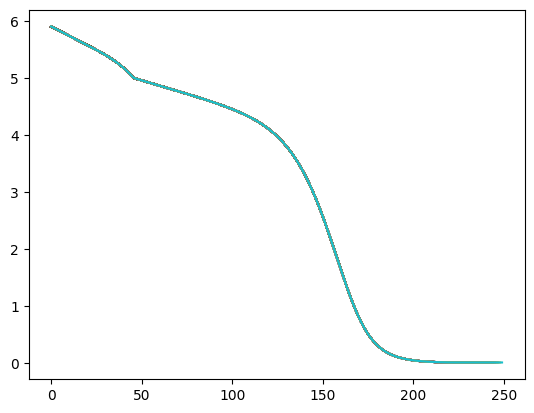

In [98]:
ls = []
model = model.to('cuda')
plotno = 0
trigger = 1
prev = 99999999999
for t in range(250):
    print(f"Epoch: {t+1}\n------------------")
    ls  = train_loop(dataloader,model,loss,opt,700,ls, f"ModelPlot.png", scheduler)
    if ls[-1] <= 0.017 and trigger == 1:
        opt = torch.optim.ASGD(model.parameters(), lr=0.0027)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10, verbose=True)
        trigger += 1
        print("\n\n Switch From Adam to SGD \n\n")
      #  plotno+=1
    plt.plot(ls)
    plt.savefig(f"LossPlot{plotno}.png")

In [99]:
dataset2 = DataFrameDataset(test_df)
dataloader2 = DataLoader(dataset2, batch_size=700, shuffle = True)
print(dataset2.__len__())
print(len(dataloader2))

300
1


In [100]:
import random

In [101]:
model = model.to('cpu')
for batch, (X, Y) in enumerate(dataloader2):
    Y1 = model(X)
    #Y2 = model2(X)
    Y1,Y = Y1.detach().numpy(),Y.detach().numpy()
    m1 = abs(metrics.r2_score(Y1,Y))
    idx = random.randrange(300)
    #print(*Y1[idx], Y[idx])
    #m2 = metrics.r2_score(Y2,Y)
    m2 = metrics.mean_squared_error(Y,Y1)
    m3 = metrics.mean_absolute_error(Y,Y1)
    #print(f'acc = {1 - m3/avg}')
    #print(m1,m2)
    break
res = {"Model":"ArpitSModel",
       "MSE Error": m2,
       "MAE Error": m3, 
       "Accuracy": (1- m3/avg),
       "R2 Score": m1}
rsqval = m1
result = pd.DataFrame([res])
result.head()

,Model,MSE Error,MAE Error,Accuracy,R2 Score
0,ArpitSModel,0.000424,0.015987,0.457182,0.983652


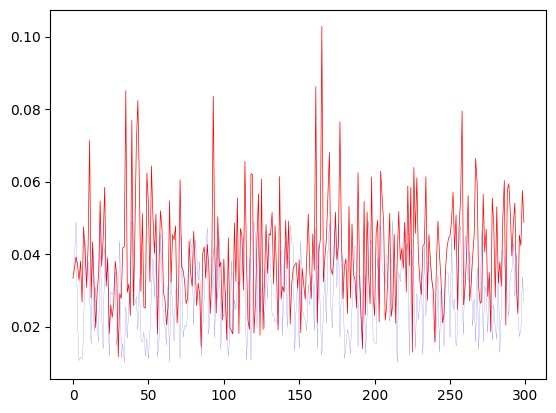

In [102]:
plt.plot(Y1, color= 'r',linewidth = 0.5)
plt.plot(Y, color= 'b',linewidth = 0.1)
plt.show()

In [103]:
for batch, (X, Y) in enumerate(dataloader):
    Y1 = model(X)
    #Y2 = model2(X)
    Y1,Y = Y1.detach().numpy(),Y.detach().numpy()
    m = metrics.r2_score(Y1,Y)
    
    idx = random.randrange(len(dataloader))
    print(*Y1[idx], Y[idx])
    m2 = metrics.mean_squared_error(Y,Y1)
    print(m, m2)
    m3 = metrics.mean_absolute_error(Y,Y1)
    print(f'acc = {1 - m3/avg}')
    break

0.035972223 0.04327606
-0.9937332482770374 0.0003882286
acc = 0.4758470210764647


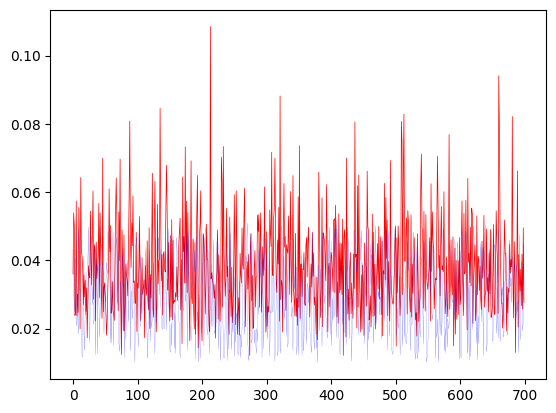

In [104]:
plt.plot(Y1, color= 'r',linewidth = 0.5)
plt.plot(Y, color= 'b',linewidth = 0.1)
plt.show()

In [105]:
torch.save(model,f"ModelW{int(m1*100)}RSq.pth")